In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
df_train = pd.read_csv('/content/Train.csv')
df_valid = pd.read_csv('/content/Valid.csv')
df_test = pd.read_csv('/content/Test.csv')

In [33]:
df_train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [34]:
print("Train shape:", df_train.shape)
print("Valid shape:", df_valid.shape)
print("Test shape:", df_test.shape)

Train shape: (40000, 2)
Valid shape: (5000, 2)
Test shape: (5000, 3)


In [46]:
# df_test.head()

,id,text,label
0,0,I always wrote this series off as being a comp...,NaN
1,1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,NaN
2,2,This movie was so poorly written and directed ...,NaN
3,3,The most interesting thing about Miryang (Secr...,NaN
4,4,"when i first read about ""berlin am meer"" i did...",NaN


In [35]:
df_valid.dropna(inplace=True)

In [36]:
print(df_test['label'].unique())

[nan]


In [8]:
print(df_train['label'].isnull().sum())
print(df_valid['label'].isnull().sum())
print(df_test['label'].isnull().sum())

0
0
0


In [20]:
print(df_train['label'].value_counts())

label
0    20019
1    19981
Name: count, dtype: int64


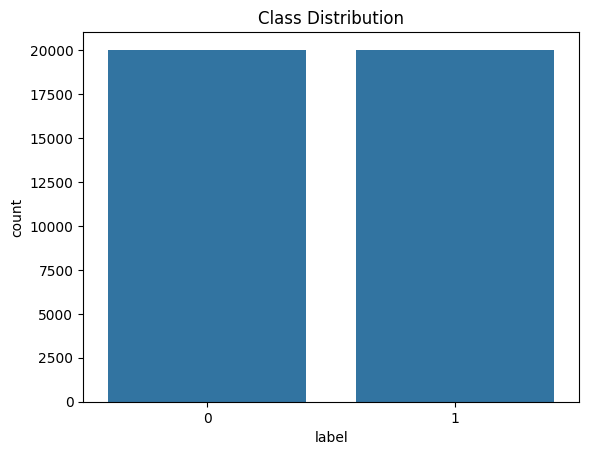

In [8]:
#Class Distribution
sns.countplot(x='label', data=df_train)
plt.title("Class Distribution")
plt.show()

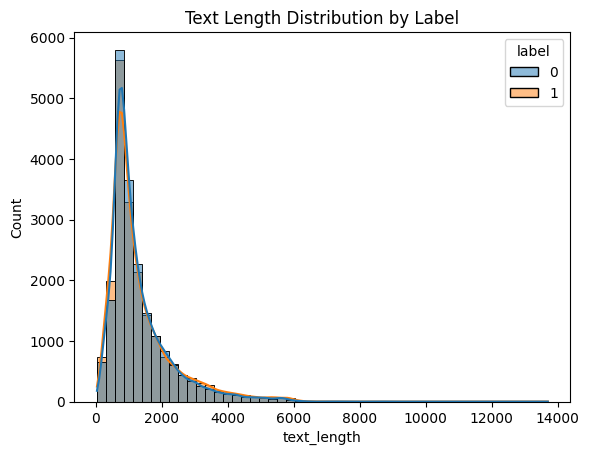

In [9]:
#Text Length Analysis
df_train['text_length'] = df_train['text'].apply(len)
sns.histplot(data=df_train, x='text_length', hue='label', bins=50, kde=True)
plt.title("Text Length Distribution by Label")
plt.show()

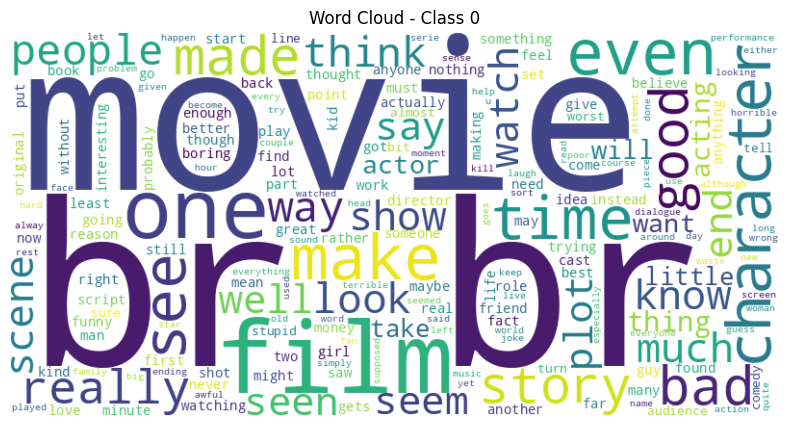

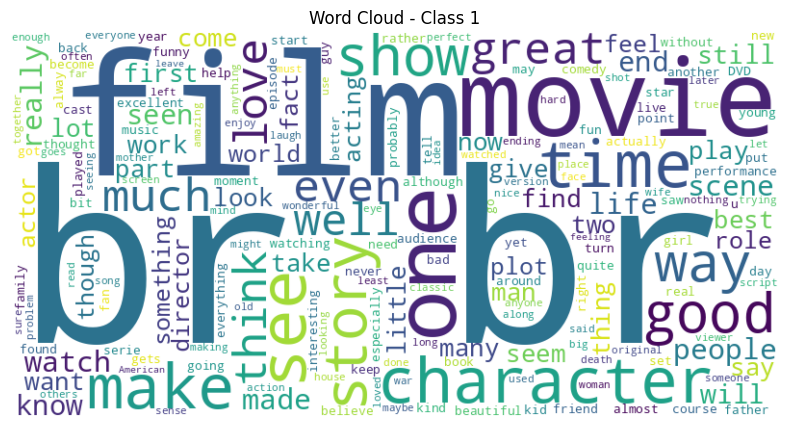

In [10]:
#Word Cloud for Each Class
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Combine texts per class
class_0_text = " ".join(df_train[df_train['label'] == 0]['text'])
class_1_text = " ".join(df_train[df_train['label'] == 1]['text'])

generate_word_cloud(class_0_text, "Word Cloud - Class 0")
generate_word_cloud(class_1_text, "Word Cloud - Class 1")

In [37]:
#  Text Preprocessing
def preprocess_text(text):
    # Remove URLs, mentions, special characters
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    # Lowercase
    text = text.lower()

    # Tokenize and remove stopwords
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [38]:
df_train['cleaned_text'] = df_train['text'].apply(preprocess_text)
df_valid['cleaned_text'] = df_valid['text'].apply(preprocess_text)

In [39]:
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(df_train['cleaned_text'])
X_valid = tfidf.transform(df_valid['cleaned_text'])
# Show top words by average TF-IDF score
feature_array = np.array(tfidf.get_feature_names_out())
tfidf_scores = X_train.mean(axis=0).A1
top_indices = tfidf_scores.argsort()[-20:][::-1]

print("Top words by TF-IDF:")
for idx in top_indices:
    print(feature_array[idx], tfidf_scores[idx])

Top words by TF-IDF:
br 0.06565838668267505
movie 0.05662754894135166
film 0.04763438613485757
one 0.03210398397894179
like 0.027730423921030097
good 0.02430648793219916
really 0.02093510704553635
would 0.020440401458350275
story 0.020167290262293865
even 0.020147519133131814
see 0.020135365351350066
time 0.01979683587909122
bad 0.018970640826347557
great 0.01847230264013756
well 0.01707534538551385
movies 0.016949168297643848
much 0.016921299775245625
dont 0.016878495726370495
people 0.01682918077848968
get 0.016542459254749654


In [40]:
X_train_tfidf = X_train
y_train = df_train['label']

X_valid_tfidf = X_valid
y_valid = df_valid['label']

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model_lr = LogisticRegression()
model_lr.fit(X_train_tfidf, y_train)

preds = model_lr.predict(X_valid_tfidf)
print("Validation Accuracy:", accuracy_score(y_valid, preds))
print(classification_report(y_valid, preds))

Validation Accuracy: 0.8812
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2486
           1       0.87      0.90      0.88      2514

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [48]:
# التنبؤ على البيانات الجديدة
texts_to_predict = df_test['text'].fillna('')  # أو 'cleaned_text' إذا كان موجود
X_test_tfidf = tfidf.transform(texts_to_predict)

# التنبؤ
y_test_preds = model_lr.predict(X_test_tfidf)

# حفظ النتائج
df_test['label'] = y_test_preds

In [49]:
df_test['label'].head()

,label
0,0
1,0
2,0
3,1
4,0


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [16]:
vectorizer = CountVectorizer(max_features=5000)
X_train_count = vectorizer.fit_transform(df_train['cleaned_text'])
X_valid_count = vectorizer.transform(df_valid['cleaned_text'])

In [17]:
model = LogisticRegression()
model.fit(X_train_count, y_train)

preds = model.predict(X_valid_count)
print("Validation Accuracy:", accuracy_score(y_valid, preds))
print(classification_report(y_valid, preds))

Validation Accuracy: 0.8722
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2486
           1       0.87      0.88      0.87      2514

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
#Naive Bayes (TF-IDF)
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, df_train['label'])
preds = model_nb.predict(X_valid_tfidf)
print("Naive Bayes Accuracy:", accuracy_score(df_valid['label'], preds))
print(classification_report(df_valid['label'], preds))

Naive Bayes Accuracy: 0.8504
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2486
           1       0.84      0.86      0.85      2514

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [19]:
#SVM (TF-IDF)
model_svm = LinearSVC()
model_svm.fit(X_train_tfidf, df_train['label'])
preds = model_svm.predict(X_valid_tfidf)
print("SVM Accuracy:", accuracy_score(df_valid['label'], preds))
print(classification_report(df_valid['label'], preds))

SVM Accuracy: 0.8792
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2486
           1       0.87      0.89      0.88      2514

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [22]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train_tfidf, df_train['label'])
preds = model_rf.predict(X_valid_tfidf)
print("Random Forest Accuracy:", accuracy_score(df_valid['label'], preds))
print(classification_report(df_valid['label'], preds))

Random Forest Accuracy: 0.8434
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2486
           1       0.85      0.84      0.84      2514

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



In [57]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train_tfidf, df_train['label'])
preds_xgb = model_xgb.predict(X_valid_tfidf)

print("XGBoost Accuracy:", accuracy_score(df_valid['label'], preds_xgb))
print(classification_report(df_valid['label'], preds_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:39:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8526
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2486
           1       0.84      0.88      0.86      2514

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [58]:
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(max_iter=500)
model_log.fit(X_train_tfidf, df_train['label'])
preds_log = model_log.predict(X_valid_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(df_valid['label'], preds_log))
print(classification_report(df_valid['label'], preds_log))

Logistic Regression Accuracy: 0.8812
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2486
           1       0.87      0.90      0.88      2514

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [41]:
# Deep Learning – LSTM
# Keras + Tokenizer + Embedding Layer.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Prepare data
MAX_LEN = 100
VOCAB_SIZE = 10000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['cleaned_text'])

X_train_seq = tokenizer.texts_to_sequences(df_train['cleaned_text'])
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_valid_seq = tokenizer.texts_to_sequences(df_valid['cleaned_text'])
X_valid_pad = pad_sequences(X_valid_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model_lstm = Sequential([
    Embedding(VOCAB_SIZE,128, input_length=MAX_LEN),
    Bidirectional(LSTM(128)),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [43]:
model_lstm.fit(X_train_pad, df_train['label'], epochs=20, validation_data=(X_valid_pad,df_valid['label'])) #evaluate

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7673 - loss: 0.4782 - val_accuracy: 0.8594 - val_loss: 0.3271
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8993 - loss: 0.2584 - val_accuracy: 0.8704 - val_loss: 0.3331
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9286 - loss: 0.1889 - val_accuracy: 0.8618 - val_loss: 0.3588
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9537 - loss: 0.1271 - val_accuracy: 0.8522 - val_loss: 0.4206
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9715 - loss: 0.0858 - val_accuracy: 0.8530 - val_loss: 0.4928
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9804 - loss: 0.0612 - val_accuracy: 0.8496 - val_loss: 0.6329
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9856 - loss: 0.0442 - val_accuracy: 0.8240 - val_loss: 0.6862
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9926 -

In [44]:
df_test['text'] = df_test['text'].fillna('')  # تعويض النصوص الفارغة بنص فارغ

X_test_seq = tokenizer.texts_to_sequences(df_test['text'])
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

y_pred_probs = model_lstm.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

df_test['label'] = y_pred

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [45]:
df_test.to_csv("test_with_predictions.csv", index=False)

In [66]:
loss, acc = model_lstm.evaluate(X_test_pad, df_test['label'])
print("GRU Test Accuracy:", acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8316 - loss: 0.8384
GRU Test Accuracy: 0.8289999961853027


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

VOCAB_SIZE = 10000  # حجم المفردات (مثل الـ tokenizer)
MAX_LEN = 100       # طول التسلسل

model_gru = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
    GRU(128),
    Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [63]:
history = model_gru.fit(
    X_train_pad,
    df_train['label'],
    epochs=20,
    batch_size=32,
    validation_data=(X_valid_pad, df_valid['label']),
    verbose=1
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5677 - loss: 0.6619 - val_accuracy: 0.8404 - val_loss: 0.3596
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8728 - loss: 0.3068 - val_accuracy: 0.8434 - val_loss: 0.3621
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9090 - loss: 0.2337 - val_accuracy: 0.8680 - val_loss: 0.3217
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9376 - loss: 0.1674 - val_accuracy: 0.8472 - val_loss: 0.3964
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9626 - loss: 0.1060 - val_accuracy: 0.8430 - val_loss: 0.4535
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9805 - loss: 0.0611 - val_accuracy: 0.8442 - val_loss: 0.5191
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9873 - loss: 0.0430 - val_accuracy: 0.8440 - val_loss: 0.6481
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9918 - loss

In [64]:
y_pred_probs = model_gru.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
df_test['label'] = y_pred
df_test['label'].head()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,label
0,0
1,0
2,0
3,0
4,0


In [65]:
loss, acc = model_gru.evaluate(X_test_pad, df_test['label'])
print("GRU Test Accuracy:", acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0245
GRU Test Accuracy: 1.0


In [59]:
# CNN + Embeddings: تصنيف نصوص باستخدام شبكة عصبية تلافيفية.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

VOCAB_SIZE = 10000   # حجم المفردات (تأكد إنه نفس قيمة الـ tokenizer)
MAX_LEN = 100        # طول التسلسل

model_cnn = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
history = model_cnn.fit(
    X_train_pad,
    df_train['label'],
    epochs=10,
    batch_size=32,
    validation_data=(X_valid_pad, df_valid['label']),
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7109 - loss: 0.5175 - val_accuracy: 0.8462 - val_loss: 0.3377
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8897 - loss: 0.2760 - val_accuracy: 0.8540 - val_loss: 0.3325
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9389 - loss: 0.1635 - val_accuracy: 0.8458 - val_loss: 0.3755
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9675 - loss: 0.0911 - val_accuracy: 0.8482 - val_loss: 0.4487
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9806 - loss: 0.0568 - val_accuracy: 0.8454 - val_loss: 0.5167
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9835 - loss: 0.0466 - val_accuracy: 0.8460 - val_loss: 0.6010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9864 - loss: 0.0370 - val_accuracy: 0.8478 - val_loss: 0.6306
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9893 - loss: 0.0317

In [61]:
y_pred_probs = model_cnn.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
df_test['label'] = y_pred
df_test['label'].head()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,label
0,0
1,0
2,0
3,1
4,0


In [67]:
loss, acc = model_cnn.evaluate(X_test_pad, df_test['label'])
print("GRU Test Accuracy:", acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8099 - loss: 0.6804
GRU Test Accuracy: 0.8037999868392944


In [50]:
#Use BERT Sentence Embeddings
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

# Convert texts to BERT embeddings
X_train_bert = bert_model.encode(df_train['cleaned_text'].tolist(), convert_to_numpy=True)
X_valid_bert = bert_model.encode(df_valid['cleaned_text'].tolist(), convert_to_numpy=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [51]:
#Train classifier
model_bert = LogisticRegression()
model_bert.fit(X_train_bert,df_train['label'])
preds = model_bert.predict(X_valid_bert)

print("BERT Accuracy:", accuracy_score(df_valid['label'], preds))
print(classification_report(df_valid['label'], preds))

BERT Accuracy: 0.8354
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2486
           1       0.83      0.85      0.84      2514

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
df_test['text'] = df_test['text'].fillna('')  # تعويض النصوص الفارغة إن وجدت
X_test_bert = bert_model.encode(df_test['text'].tolist(), convert_to_numpy=True)

In [54]:
y_test_pred = model_bert.predict(X_test_bert)

In [55]:
df_test['label'] = y_test_pred

In [56]:
df_test.to_csv("test_with_bert_predictions.csv", index=False)